In [75]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bomeba0 as bmb
from numba import jit

In [76]:
n = 20
prot = bmb.Protein('A' * n)
#ang = np.random.uniform(-180, 180, size=(n, 2))
#for i in range(0, len(prot)):
#    phi, psi = ang[i]
#    prot.set_phi(i, phi)
#    prot.set_psi(i, psi)

def fragments(prot):
    """
    Takes a Protein object and returns a list.
    of it's fragmented coordinates.
    ----------------
    Parameters
    ----------------
    prot: Protein object
    
    -----------------
    Returns
    -----------------
    selec: List of selected coordinates.
    """
    xyz = prot.coords
    boxes = bmb.OBB._little_boxes(prot)
    selec =  [xyz.take(i, 0) for i in  boxes]
    return selec

selec = fragments(prot)
frag = np.concatenate(selec)

* Intenté acelerar np.dot(), pero solo logré igualar la velocidad de numpy!
* Al parecer es posible usarla descomposición QR en vez de los autovalores (esto hay que evaluarlo)
* De forma llamativa np.linalg.qr como np.linalg.eigh se pueden acelerar con numba. 

In [77]:
@jit()
def eigh(A):
    return np.linalg.eigh(A)[1]

# https://github.com/danbar/qr_decomposition
@jit
def qr(cov):
    return np.linalg.qr(cov)[0]

@jit
def mini(xyz):
    return np.min(xyz[:,0]), np.min(xyz[:,1]), np.min(xyz[:,2])

@jit
def maxi(xyz):
    return np.max(xyz[:,0]), np.max(xyz[:,1]), np.max(xyz[:,2])

In [78]:
class Node:    
    
    """Constructor to create a new node"""
    
    def __init__(self, coord, parents, children):
        self.obb = vertex_OBB(coord)
        self.parents = parents
        self.children = children
        
    def __str__(self):
        return '{}'.format(self.obb, self.parents, self.children)
    
    def get_dot(self, index):
        """
        Gets the coodinates of a dot given an index for it as in:
        https://cdn.tutsplus.com/gamedev/uploads/legacy/008_separatingAxisTheorem/assets/conventions.jpg        
        """
        if index == 0:
            return np.array([np.average(self.obb[0][:,0]),
                            np.average(self.obb[0][:,1]),
                            np.average(self.obb[0][:,2])])
        else:
            return self.obb[0][index-1,:]

def vertex_OBB(XYZ):
        """
        Computes the 8 vertex of the Oriented Bounding Box

        Parameters:
        -----------
        XYZ : array of shape (n,3).
            Contains the coordinates of the atoms to be enclosed by the OBB.  
              

        Returns:
        -----------
        vertex : OBB coordinates
        eigen_vecs : transformation matrix
        vertex_no : XYZ
        """
        # Compute scatter matrix
        scat = np.dot(XYZ.T, XYZ)
        # Compute qr decomposition
        eigen_vecs = qr(scat)
        # Compute eigenvalues
        #eigen_vecs = eigh(scat)
        # project XY onto the "principal axes"
        XYZ_proj = np.dot(XYZ, eigen_vecs)
        # compute min/max values
        min_x, min_y, min_z = mini(XYZ_proj)
        max_x, max_y, max_z = maxi(XYZ_proj)

        Sr = 1.80 #S radius
        min_x, min_y, min_z = min_x - Sr, min_y - Sr, min_z - Sr
        max_x, max_y, max_z = max_x + Sr, max_y + Sr, max_z + Sr
        
        ver_proj_S = np.array([[max_x, max_y, max_z],
                               [max_x, min_y, max_z],
                               [min_x, min_y, max_z],
                               [min_x, max_y, max_z],
                               [max_x, max_y, min_z],
                               [max_x, min_y, min_z],
                               [min_x, min_y, min_z],
                               [min_x, max_y, min_z]])

        # project min/max values back to the original system
        vertex_proj = np.dot(ver_proj_S, eigen_vecs.T)
        #vertex_no = ver_proj @ eigen_vecs.T
        return vertex_proj, eigen_vecs, XYZ

def dimensions(node):
    """
    Computes width, height and depth of an OBB,
    contained in a node object.
    
    ----------------
    Parameters:
    ----------------
    node: node object
    """
    width = np.max(node.obb[0][:,0]) - np.min(node.obb[0][:,0])
    height = np.max(node.obb[0][:,1]) - np.min(node.obb[0][:,1])
    depth = np.max(node.obb[0][:,2]) - np.min(node.obb[0][:,2])
    return [width, height, depth]

def create_nodes(selec):
        """
        Creates every node

        Parameters:
        -----------
        selec : list of arrays containing selection coordinates
        
        Returns:
        -----------
        nodes: (list of lists)
            every level in the hierarchy and every node in each level
        """
        lower_layer = [Node(i, parents=1, children=0) for i in selec]

        combined = combine(lower_layer)
        
        nodes = [lower_layer]

        for _ in selec:
            layer = []
            for node_list in combined:
                if len(node_list) == 1:
                    layer.append(node_list[0])
                else:
                    c = np.concatenate((node_list[0].obb[2], node_list[1].obb[2]))
                    layer.append(Node(c, parents = 1, children = 2))

            combined = combine(layer)
            nodes.append(layer)
            if len(combined[0]) == 1:
                break
        return nodes


def combine(layer):
    """
    group nodes in layer two by two.
    If nodes are odd, the last node will be unpaired.

    Parameters:
    -----------
    layer : list
        list of nodes
    """
    return [layer[n:n+2] for n in range(0, len(layer), 2)]

In [79]:
nodes = create_nodes(selec)

In [80]:
nodes[0][5].get_dot(1)

array([-51.69704882, -29.90324747,   2.03042265])

In [81]:
%timeit create_nodes(selec)
%timeit prot.energy()

100 loops, best of 3: 3.46 ms per loop
100 loops, best of 3: 3.55 ms per loop


<IPython.core.display.Javascript object>


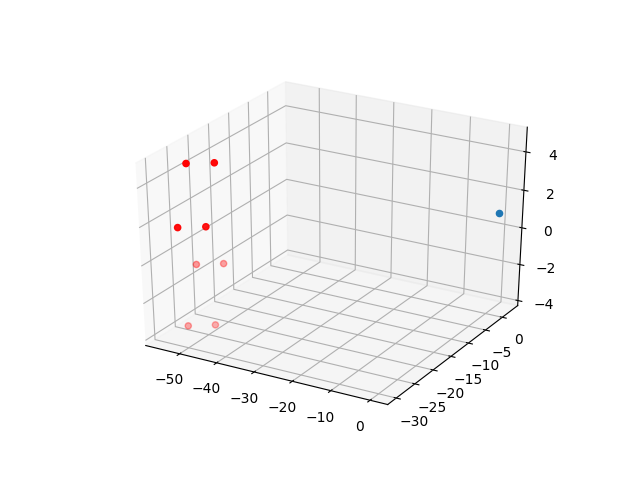

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(frag[:,0], frag[:,1], frag[:,2], c='g')
ax.scatter( 0.39791296,  2.33033074,  0.9413822)
#ax.scatter(q[:,0], q[:,1], q[:,2], c='m')

lv1 = 0
lv2 = -2
bx = 0
ax.scatter(nodes[lv1][5].obb[0][:,0],  nodes[lv1][5].obb[0][:,1], nodes[lv1][5].obb[0][:,2], c ='r')#
#ax.scatter(nodes[lv2][0].obb[0][:,0],  nodes[lv2][0].obb[0][:,1], nodes[lv2][0].obb[0][:,2], c ='b')#
#ax.scatter(nodes[lv2][bx+1].obb[0][:,0],  nodes[lv2][bx+1].obb[0][:,1], nodes[lv2][bx+1].obb[0][:,2], c ='y')#

#### box for whole protein is the same than the one computed bottom-up
box = vertex_OBB(frag)[0]
#ax.scatter(box[:,0] , box[:,1] , box[:,2], c='b')

In [83]:
def collide(hierarchy, level, a , b):
    """
    Determines if two nodes collide.
    
    -----------------
    Parameters:
    -----------------
    
    hierarchy: output of create_nodes function. List of lists
    level: int. Level in the hierarchy.
    a, b: int. Index of the nodes in  a level.
    """
    
    axis = (np.any(np.absolute(hierarchy[level][a].obb[0][:,0]-hierarchy[level][b].obb[0][:,0]) * 2 < (dimensions(hierarchy[level][a])[0] + dimensions(hierarchy[level][b])[0])),
            np.any(np.absolute(hierarchy[level][a].obb[0][:,1]-hierarchy[level][b].obb[0][:,1]) * 2 < (dimensions(hierarchy[level][a])[1] + dimensions(hierarchy[level][b])[1])),
            np.any(np.absolute(hierarchy[level][a].obb[0][:,2]-hierarchy[level][b].obb[0][:,2]) * 2 < (dimensions(hierarchy[level][a])[2] + dimensions(hierarchy[level][b])[2])))
    return np.any(axis)

In [84]:
def DoBoxesIntersect(BVH):
    """
    Read a BVH from the top to the bottom,
    and detect colliding nodes. 
    
    -----------------
    Parameters:
    -----------------
    BVH: list of lists. Output of create nodes function. 
    """
    algo = [] 
    for level in range(2, len(BVH)):
        for node in range(0, len(BVH[-level]) - 1):
            for neighbour in range(node, len(BVH[-level])):
                algo.append(collide (BVH, -level, node, neighbour))
    return algo

In [89]:
#DoBoxesIntersect(nodes)

In [86]:
length = nodes[-3][0].obb[0][:,0] - nodes[-3][0].obb[0][:,0]
half_width_box1 = dimensions(nodes[-2][0])[0] * 0.5
half_width_box2 = dimensions(nodes[-2][1])[0] * 0.5

gap_between_boxes = length - half_width_box1 - half_width_box2

if np.any(gap_between_boxes) > 0 : print('its a big gap')
elif np.any(gap_between_boxes) == 0 : print('theyre touching')
elif np.any(gap_between_boxes) < 0 : print('theyre penetrating')

its a big gap


In [90]:
#box1
box1 = nodes[0][0]
# box2
box2 = nodes[0][14]
# var dot10:Point = box1.getDot(0);
dot10 = box1.get_dot(0)
# var dot11:Point = box1.getDot(1);
dot11 = box1.get_dot(1)
 
# var dot20:Point = box2.getDot(0);
dot20 = box2.get_dot(0)
# var dot24:Point = box2.getDot(4);
dot24 = box2.get_dot(4)

# //Actual calculations
# var axis:Vector2d = new Vector2d(1, -1).unitVector;
axis = np.array([-1, -1, 1]) # ???
# var C:Vector2d = new Vector2d(
#     dot20.x - dot10.x,
#     dot20.y - dot10.y
# )
C = np.array([dot20[0] - dot10[0], dot20[1] - dot10[1], dot20[2] - dot10[2]])
# var A:Vector2d = new Vector2d(
#     dot11.x - dot10.x,
#     dot11.y - dot10.y
# )
A = np.array([dot11[0] - dot10[0], dot11[1] - dot10[1], dot11[2] - dot10[2]])

# var B:Vector2d = new Vector2d(
#     dot24.x - dot20.x,
#     dot24.y - dot20.y
# )
B = np.array([dot24[0] - dot20[0], dot24[1] - dot20[1], dot24[2] - dot20[2]])

# var projC:Number = C.dotProduct(axis)
projC = np.dot(C, axis)
# var projA:Number = A.dotProduct(axis);
projA = np.dot(A, axis)
# var projB:Number = B.dotProduct(axis);
projB = np.dot(B, axis)
 
# var gap:Number = projC - projA + projB; //projB is expected to be a negative value
gap = projC - projA + projB

# if (gap > 0) t.text = "There's a gap between both boxes"
if gap > 0 :print("There's a gap between both boxes")
# else if (gap > 0) t.text = "Boxes are touching each other"
if gap == 0: print("Boxes are touching each other")
# else t.text = "Penetration had happened."
else: print("Penetration had happened.")

Penetration had happened.
